# **Fraud Detection Project**

### Importing Necassary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics, model_selection
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Import libraries used for Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [2]:
# Retrieving the dataset
df = pd.read_csv("fraud_data.csv", na_values='?')
df = df.dropna()

### Correlation Matrix Between Features Using HeatMap

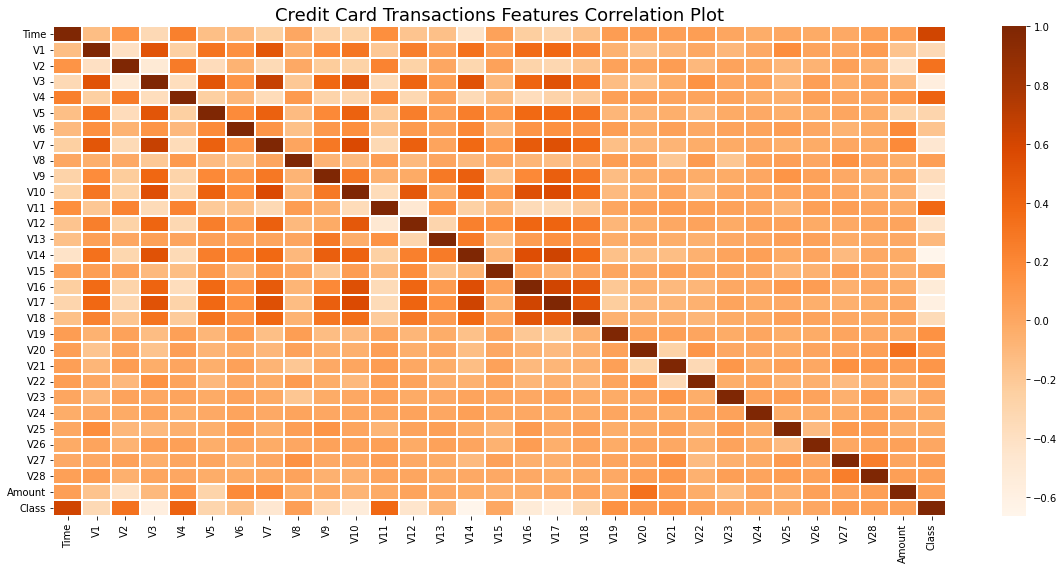

In [4]:
# Correlation table
correlation = df.corr()
correlation["Class"].sort_values(ascending=False)
# Plotting Corr. Matrix
plt.figure(figsize=(20, 9))
plt.title("Credit Card Transactions Features Correlation Plot", fontsize=18)
sns.heatmap(
    correlation,
    xticklabels=correlation.columns,
    yticklabels=correlation.columns,
    linewidth=2,
    cmap="Oranges",
    cbar=True,
)
plt.show()

### Eliminating features whose correlation value is greater than 0.75 

In [5]:
columns = list(df.columns)
for column in columns:
    # Skip Class column
    if column == "Class":
        continue
    filtered_columns = [column]
    # Iterate through HeatMap
    for col in df.columns:
        # Skip the diagonals and the class columns
        if (column == col) | (column == "Class"):
            continue
        # Retrieving corr val from df
        cor_val = df[column].corr(df[col])
        # Setting threshold to be 70%
        if cor_val > 0.75:
            columns.remove(col)
            continue
        else:
            filtered_columns.append(col)
    # Keeping only filtered columns
    df = df[filtered_columns]

features = df.drop(["Class"], axis=1)
# We are gonig to scale the featrues with MinMax Scaler
mm_scaler = MinMaxScaler((0,1))
X = mm_scaler.fit_transform(features)

#<--> Lines (31-33) Cited

# Using Chi Squared to filter columns
selector = SelectKBest(chi2, k=21)
selector.fit(X, df["Class"])
filtered_columns = selector.get_support()

# Adding Class column back to dataframe
filtered_data = features.loc[:, filtered_columns]
df = filtered_data.join(df["Class"])

print("After filtering highly correlated features, dataset is ", df.shape)

After filtering highly correlated features, dataset is  (20000, 22)


### Observation
Let's observe the dataset and find connection between fraudulant and normal transactions. 

In [6]:
#temp_df = df.sort_values(by = ["Time"])
frauds = df.query("Class == 1")
normals = df.query("Class == 0")
total = len(df)
fraud_percent = round((len(frauds) / total)*100, 2)
print("The percentage of fraudulant transactions is: ", fraud_percent)

The percentage of fraudulant transactions is:  2.46


As the percentage of fraudulant transactions is trivial making the dataset strongly imbalanced,so we might apply the following: 
1. Increase the number of samples from minority class
2. Decrease the number of samples from majority class \
\
We can also penalyze the algorithm to achieve better scores for the following metrics: Confusion Matrix, Precision, Recall, F1-score, AOC.

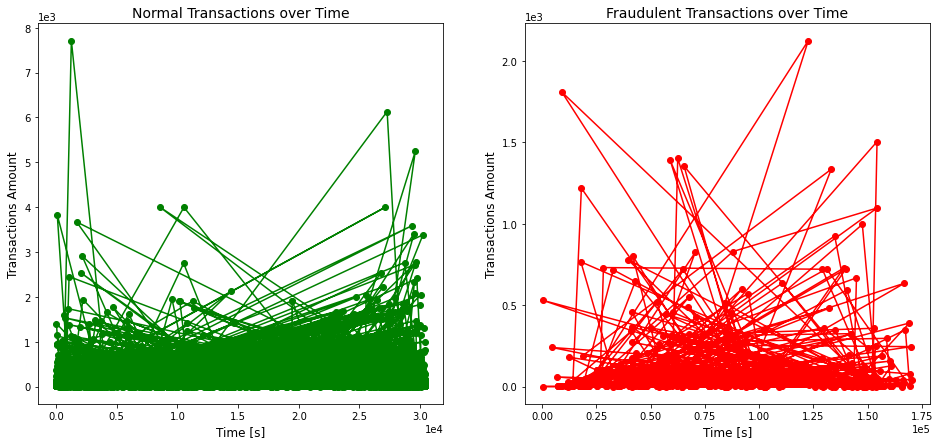

In [7]:
# Function to plot based on the passed arguments
def plot_line(x, y, title="", xlabel="", ylabel="", color=""):
    plt.plot(x, y, color)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

plt.figure(figsize=(16, 7))
# Normal transactions on amount vs time chart
plt.subplot(1, 2, 1)
plot_line(
    x=normals["Time"],
    y=normals["Amount"],
    title="Normal Transactions over Time",
    xlabel="Time [s]",
    ylabel="Transactions Amount",
    color="g-o",
)
# Fraudulant transactions on amount vs time chart
plt.subplot(1, 2, 2)
plot_line(
    x=frauds["Time"],
    y=frauds["Amount"],
    title="Fraudulent Transactions over Time",
    xlabel="Time [s]",
    ylabel="Transactions Amount",
    color="r-o",
)

In [8]:
std_scaler = StandardScaler()
# Retrieving amount values to rescale
amount_vals = df['Amount'].values
# Standard Scaling amount values and reshaping as a column.
df['Amount'] = std_scaler.fit_transform(amount_vals.reshape(-1,1))

### Splitting Data & Creating Training Structures

In [9]:
y = np.array(df['Class'])
X = np.array(df.loc[:, df.columns != 'Class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10, shuffle=True)
print("Before oversampling the data: ")
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("\n")

# We are going to oversample the dataset and create new synthetic data samples resembling the minority class
ros = RandomOverSampler(sampling_strategy="minority", random_state=1)
X_train, y_train = ros.fit_resample(X_train, y_train)

print("After oversampling the data: ")
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)

# models = []
scores = ["precision", "accuracy", "recall", "F1", "ROC"]
confusion_matrix_results = {}


Before oversampling the data: 
X_train Shape:  (16000, 21)
X_test Shape:  (4000, 21)


After oversampling the data: 
X_train Shape:  (31228, 21)
X_test Shape:  (4000, 21)


### Logistic Regression

In [9]:
# Let's start by testing logistic regression accuracy without regularization on a variety of different feature transformations
for i in range(1, 4):
    poly = PolynomialFeatures(i)
    X_train_new = poly.fit_transform(X_train)
    X_test_new = poly.fit_transform(X_test)
    logreg = LogisticRegression(max_iter=10000000, penalty='none')
    logreg.fit(X_train_new, y_train)
    y_pred = logreg.predict(X_test_new)
    print(f'Accuracy of logistic regression with no regularization and transformation X^{i}: {logreg.score(X_test_new, y_test)}')

# As we can see, our new polynomial transformation features before worse against the test data, so we will stick
# our original train data.

# The next step will be using K-fold cross validation to help us identify the best hyperparameters
# as well as see if we can get our model's performance to improve and decrease overfitting by
# adding regularization.

best_score = [0, 0, 0]
best_y_pred = None

print("--------------------")
C = [0.0001, 0.1, 1, 10, 100, 1000, 1000000]
for k in range(7):
    L2_logreg = LogisticRegressionCV(Cs=C, cv=k+3, max_iter=100000)
    L2_logreg.fit(X_train, y_train)
    y_pred = L2_logreg.predict(X_test)
    score = L2_logreg.score(X_test, y_test)
    print(f'Logistic Regression Accuracy with K^{k+3}, L2 Regularization and C={max(L2_logreg.C_)} is: {score}')

    if score > best_score[0]:
        best_score[0], best_score[1] = score, max(L2_logreg.C_)
        best_score[2] = 2
        best_y_pred = y_pred

    L1_logreg = LogisticRegressionCV(Cs=C, cv=k+3, max_iter=100000, penalty='l1', solver='liblinear')
    L1_logreg.fit(X_train, y_train)
    y_pred = L1_logreg.predict(X_test)
    score = L1_logreg.score(X_test, y_test)
    print(f'Logistic Regression Accuracy with K^{k+3}, L1 Regularization and C={max(L1_logreg.C_)} is: {score}')

    if score > best_score[0]:
        best_score[0], best_score[1] = score, max(L2_logreg.C_)
        best_score[2] = 1
        best_y_pred = y_pred

print("-------------")
print(f"Our best results were L{best_score[2]} Regularization with C={best_score[1]} and score = {best_score[0]}")

Accuracy of logistic regression with no regularization and transformation X^1: 0.98925
Accuracy of logistic regression with no regularization and transformation X^2: 0.86725


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of logistic regression with no regularization and transformation X^3: 0.9735
--------------------
Logistic Regression Accuracy with K^3, L2 Regularization and C=0.1 is: 0.9905
Logistic Regression Accuracy with K^3, L1 Regularization and C=10.0 is: 0.9915
Logistic Regression Accuracy with K^4, L2 Regularization and C=10.0 is: 0.99
Logistic Regression Accuracy with K^4, L1 Regularization and C=100.0 is: 0.9915
Logistic Regression Accuracy with K^5, L2 Regularization and C=1.0 is: 0.99175
Logistic Regression Accuracy with K^5, L1 Regularization and C=1.0 is: 0.9905
Logistic Regression Accuracy with K^6, L2 Regularization and C=100.0 is: 0.992
Logistic Regression Accuracy with K^6, L1 Regularization and C=10.0 is: 0.9905
Logistic Regression Accuracy with K^7, L2 Regularization and C=0.1 is: 0.99175
Logistic Regression Accuracy with K^7, L1 Regularization and C=1.0 is: 0.9905
Logistic Regression Accuracy with K^8, L2 Regularization and C=1.0 is: 0.9925
Logistic Regression Accuracy 

Text(0.5, 1.0, 'Accuracy Score: 0.9925')

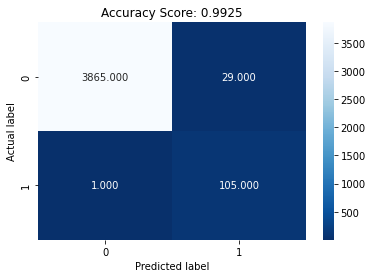

In [31]:
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt=".3f", cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {best_score[0]}'
plt.title(all_sample_title)

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Precision: %.3f' % precision_score(y_test, best_y_pred))
print('Recall: %.3f' % recall_score(y_test, best_y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, best_y_pred))
print('F1-Score: %.3f' % f1_score(y_test, best_y_pred))

Precision: 0.784
Recall: 0.991
Accuracy: 0.993
F1-Score: 0.875


### Support Vector Machine (SVM)

For the SVM, we will try a variety of feature transformations and regularization techniques using sklearn's SVM library including the following:
- Linear Kernel and L1 (Lasso regression)
- Polynomial, degree 2, L2 regularization
- Gaussian RBF with L2 regularization

We will make a plot of the test and train accuracies for all of this variation across different choices of the hyperparamter lambda.

In [10]:
# import SVC classifier, 
from sklearn.svm import SVC, LinearSVC

# Initialize some lambda values to test across SVM choices
my_lambdas = [0.0001, 0.01, 0.01, 0.1, 1, 10, 100, 1000, 10000]

We'll start off by testing variations of linear SVM with lasso regression (L1 regularization)

C=0.0001, train_score = 0.7319392852568208, test_score=0.96875
C=0.01, train_score = 0.9217369027795568, test_score=0.86025
C=0.01, train_score = 0.9408543614704752, test_score=0.95875
C=0.1, train_score = 0.9084795696170104, test_score=0.9785
C=1, train_score = 0.7161841936723453, test_score=0.98075
C=10, train_score = 0.853688997053926, test_score=0.98325
C=100, train_score = 0.8664019469706673, test_score=0.98325
C=1000, train_score = 0.8856474958370693, test_score=0.9825
C=10000, train_score = 0.9123222748815166, test_score=0.98075


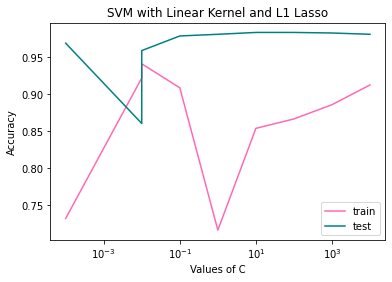

In [11]:
import warnings
test_results, train_results = [], []


for C in my_lambdas:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        svm_linear = LinearSVC(C=C, loss='hinge')
        svm_linear.fit(X_train,y_train)
        
        train_score = svm_linear.score(X_train, y_train)
        test_score = svm_linear.score(X_test, y_test)
        print(f"C={C}, train_score = {train_score}, test_score={test_score}")

    train_results.append(train_score)
    test_results.append(test_score)
    

plt.xscale("log")
plt.plot(my_lambdas, train_results, "hotpink", label="train")
plt.plot(my_lambdas, test_results, "teal", label="test")
plt.legend(loc="lower right")
plt.xlabel("Values of C")
plt.ylabel("Accuracy")
plt.title("SVM with Linear Kernel and L1 Lasso")
plt.show()

Now, we'll test SVM with linear kernel and ridge regression (L2)

We can move onto testing a new kernel function, polynomial of degree 2 because we already have lots of features. This will also use L2 regularization.

C=0.0001, train_score = 0.7530101191238632, test_score=0.987
C=0.01, train_score = 0.892148072242859, test_score=0.99425
C=0.01, train_score = 0.892148072242859, test_score=0.99425
C=0.1, train_score = 0.9141795824260279, test_score=0.99475
C=1, train_score = 0.9141795824260279, test_score=0.99475
C=10, train_score = 0.9141795824260279, test_score=0.99475
C=100, train_score = 0.912770590495709, test_score=0.99475
C=1000, train_score = 0.9103048546176509, test_score=0.9945
C=10000, train_score = 0.937556039451774, test_score=0.996


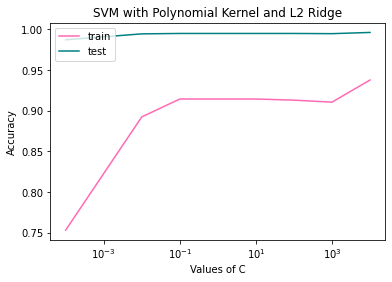

In [12]:
test_results, train_results = [], []

for C in my_lambdas:
    svm = SVC(C=C, kernel='poly', degree=2) # L2 regularization added by default
    svm.fit(X_train,y_train)
    y_pred = svm.predict(X_test)
    test_score = svm.score(X_test, y_test)
    train_score = svm.score(X_train, y_train)
    print(f"C={C}, train_score = {train_score}, test_score={test_score}")

    train_results.append(train_score)
    test_results.append(test_score)

plt.xscale("log")
plt.plot(my_lambdas, train_results, "hotpink", label="train")
plt.plot(my_lambdas, test_results, "teal", label="test")
plt.legend(loc="upper left")
plt.xlabel("Values of C")
plt.ylabel("Accuracy")
plt.title("SVM with Polynomial Kernel and L2 Ridge")
plt.show()

Finally, we'll last test the Gaussian RBF kernel transformation with ridge regression (L2).

C=0.0001, train_score = 0.8253170231843218, test_score=0.98925
C=0.01, train_score = 0.8964711156654285, test_score=0.99425
C=0.01, train_score = 0.8964711156654285, test_score=0.99425
C=0.1, train_score = 0.9116818240040989, test_score=0.99425
C=1, train_score = 0.899096964262841, test_score=0.99425
C=10, train_score = 0.9103048546176509, test_score=0.99425
C=100, train_score = 0.9153964390931215, test_score=0.99475
C=1000, train_score = 0.9547841680543102, test_score=0.9965
C=10000, train_score = 0.980498270782631, test_score=0.9975


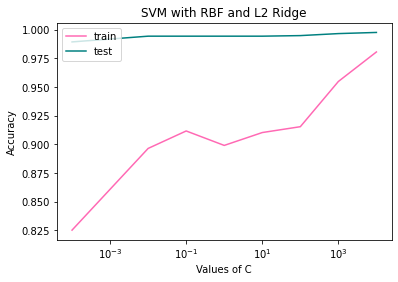

In [13]:
test_results, train_results = [], []

for C in my_lambdas:
    svm = SVC(C=C) # Default SVC uses RBF and L2
    svm.fit(X_train,y_train)
    y_pred = svm.predict(X_test)
    
    train_score = svm.score(X_train, y_train)
    test_score = accuracy_score(y_test, y_pred)
    print(f"C={C}, train_score = {train_score}, test_score={test_score}")

    train_results.append(train_score)
    test_results.append(test_score)

plt.xscale("log")
plt.plot(my_lambdas, train_results, "hotpink", label="train")
plt.plot(my_lambdas, test_results, "teal", label="test")
plt.legend(loc="upper left")
plt.xlabel("Values of C")
plt.ylabel("Accuracy")
plt.title("SVM with RBF and L2 Ridge")
plt.show()


### Artificial Neural Network (ANN)

In [ ]:
# ANN with 3 hidden layers with sizes of (4, 3, 3)
#models.append(("ANN", MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 3, 3), penalty = "l2", random_state=1)))
ann = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 3, 3), random_state=1)


### Observation